In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
def _make_divisible(ch, divisor=8, min_ch=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch

In [8]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, groups=1, relu6=True):
        super(BasicConv2d, self).__init__()
        self.relu6 = relu6
        padding = (kernel_size - 1) // 2
        if self.relu6:
            self.feature = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding, groups=groups, bias=False),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU6(inplace=True),
            )
        else:
            self.feature = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding, groups=groups, bias=False),
                nn.BatchNorm2d(num_features=out_channels),
            )

    def forward(self, x):
        out = self.feature(x)
        return out

In [9]:
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_channels = in_channels * expand_ratio
        self.use_shortcut = (stride == 1 and in_channels == out_channels)

        layers = []
        if expand_ratio != 1:
            # 1x1 pointwise conv
            layers.append(BasicConv2d(
                in_channels=in_channels, out_channels=hidden_channels, kernel_size=1))
        layers.extend([
            # 3x3 depthwise conv
            BasicConv2d(in_channels=hidden_channels, out_channels=hidden_channels,
                        stride=stride, groups=hidden_channels),
            # 1x1 pointwise conv(linear)
            BasicConv2d(in_channels=hidden_channels,
                        out_channels=out_channels, kernel_size=1, relu6=False),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [10]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=100, alpha=1.0, round_nearest=8):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        in_channels = _make_divisible(32 * alpha, round_nearest)
        last_channels = _make_divisible(1280 * alpha, round_nearest)

        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        features = []
        # conv1 layer
        features.append(BasicConv2d(in_channels=3, out_channels=in_channels, stride=2))
        # building inverted residual residual blockes
        for t, c, n, s in inverted_residual_setting:
            out_channels = _make_divisible(c * alpha, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(in_channels=in_channels, out_channels=out_channels, stride=stride, expand_ratio=t))
                in_channels = out_channels
        # building last several layers
        features.append(BasicConv2d(in_channels=in_channels, out_channels=last_channels, stride=1))
        # combine feature layers
        self.features = nn.Sequential(*features)

        # building classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channels, num_classes)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [11]:
net = MobileNetV2().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
       BasicConv2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
       BasicConv2d-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 16, 112, 112]             512
      BatchNorm2d-10         [-1, 16, 112, 112]              32
      BasicConv2d-11         [-1, 16, 112, 112]               0
 InvertedResidual-12         [-1, 16, 112, 112]               0
           Conv2d-13         [-1, 96, 112, 112]           1,536
      BatchNorm2d-14         [-1, 96, 1

In [14]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [15]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [16]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [17]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [18]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [19]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 4.593889
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.932132
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.647598
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.909628
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.697520
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.765058
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.625590
VAL set: Average loss: 0.027578, Accuracy: 3422.0/10000 (34.2%)
Validation loss decreased (inf --> 0.027578).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.553133
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.752286
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.768440
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.448799
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.540594
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.588945
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.443786
VAL set: Average loss: 0.023942, Accuracy: 4376.0/10000 (43.8%)
Validation loss decreased (0.027578 --> 0.023942).  Saving model ...

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.612383
Trai

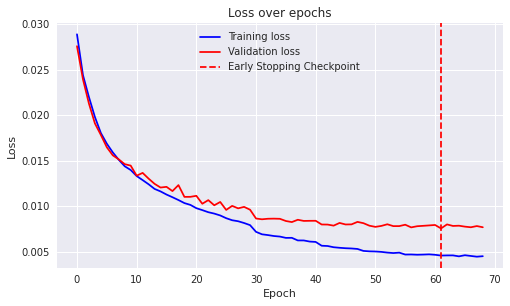

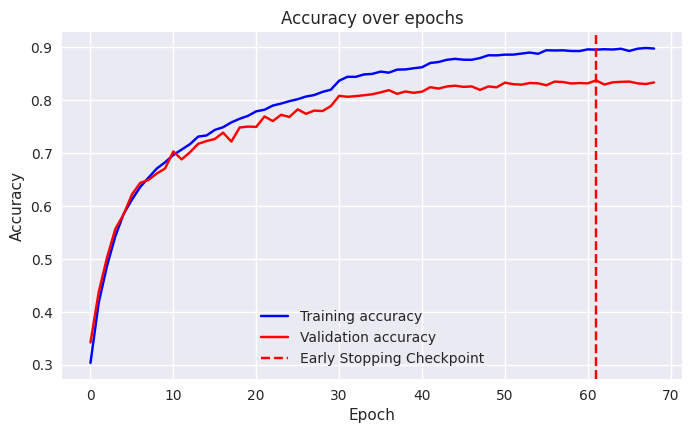

In [20]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'MobileNetV2 - predictions')

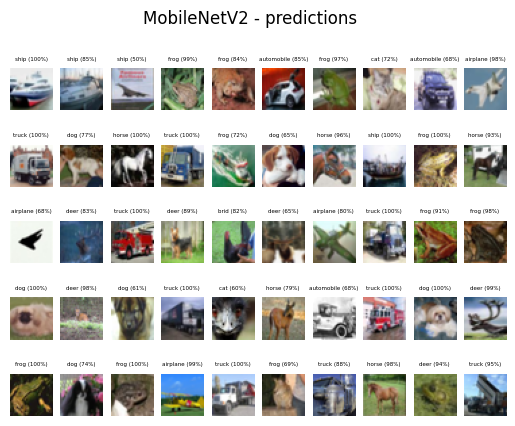

In [21]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('MobileNetV2 - predictions')

In [ ]:
"""
MobileNetV2
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
       BasicConv2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
       BasicConv2d-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 16, 112, 112]             512
      BatchNorm2d-10         [-1, 16, 112, 112]              32
      BasicConv2d-11         [-1, 16, 112, 112]               0
 InvertedResidual-12         [-1, 16, 112, 112]               0
           Conv2d-13         [-1, 96, 112, 112]           1,536
      BatchNorm2d-14         [-1, 96, 112, 112]             192
            ReLU6-15         [-1, 96, 112, 112]               0
      BasicConv2d-16         [-1, 96, 112, 112]               0
           Conv2d-17           [-1, 96, 56, 56]             864
      BatchNorm2d-18           [-1, 96, 56, 56]             192
            ReLU6-19           [-1, 96, 56, 56]               0
      BasicConv2d-20           [-1, 96, 56, 56]               0
           Conv2d-21           [-1, 24, 56, 56]           2,304
      BatchNorm2d-22           [-1, 24, 56, 56]              48
      BasicConv2d-23           [-1, 24, 56, 56]               0
 InvertedResidual-24           [-1, 24, 56, 56]               0
           Conv2d-25          [-1, 144, 56, 56]           3,456
      BatchNorm2d-26          [-1, 144, 56, 56]             288
            ReLU6-27          [-1, 144, 56, 56]               0
      BasicConv2d-28          [-1, 144, 56, 56]               0
           Conv2d-29          [-1, 144, 56, 56]           1,296
      BatchNorm2d-30          [-1, 144, 56, 56]             288
            ReLU6-31          [-1, 144, 56, 56]               0
      BasicConv2d-32          [-1, 144, 56, 56]               0
           Conv2d-33           [-1, 24, 56, 56]           3,456
      BatchNorm2d-34           [-1, 24, 56, 56]              48
      BasicConv2d-35           [-1, 24, 56, 56]               0
 InvertedResidual-36           [-1, 24, 56, 56]               0
           Conv2d-37          [-1, 144, 56, 56]           3,456
      BatchNorm2d-38          [-1, 144, 56, 56]             288
            ReLU6-39          [-1, 144, 56, 56]               0
      BasicConv2d-40          [-1, 144, 56, 56]               0
           Conv2d-41          [-1, 144, 28, 28]           1,296
      BatchNorm2d-42          [-1, 144, 28, 28]             288
            ReLU6-43          [-1, 144, 28, 28]               0
      BasicConv2d-44          [-1, 144, 28, 28]               0
           Conv2d-45           [-1, 32, 28, 28]           4,608
      BatchNorm2d-46           [-1, 32, 28, 28]              64
      BasicConv2d-47           [-1, 32, 28, 28]               0
 InvertedResidual-48           [-1, 32, 28, 28]               0
           Conv2d-49          [-1, 192, 28, 28]           6,144
      BatchNorm2d-50          [-1, 192, 28, 28]             384
            ReLU6-51          [-1, 192, 28, 28]               0
      BasicConv2d-52          [-1, 192, 28, 28]               0
           Conv2d-53          [-1, 192, 28, 28]           1,728
      BatchNorm2d-54          [-1, 192, 28, 28]             384
            ReLU6-55          [-1, 192, 28, 28]               0
      BasicConv2d-56          [-1, 192, 28, 28]               0
           Conv2d-57           [-1, 32, 28, 28]           6,144
      BatchNorm2d-58           [-1, 32, 28, 28]              64
      BasicConv2d-59           [-1, 32, 28, 28]               0
 InvertedResidual-60           [-1, 32, 28, 28]               0
           Conv2d-61          [-1, 192, 28, 28]           6,144
      BatchNorm2d-62          [-1, 192, 28, 28]             384
            ReLU6-63          [-1, 192, 28, 28]               0
      BasicConv2d-64          [-1, 192, 28, 28]               0
           Conv2d-65          [-1, 192, 28, 28]           1,728
      BatchNorm2d-66          [-1, 192, 28, 28]             384
            ReLU6-67          [-1, 192, 28, 28]               0
      BasicConv2d-68          [-1, 192, 28, 28]               0
           Conv2d-69           [-1, 32, 28, 28]           6,144
      BatchNorm2d-70           [-1, 32, 28, 28]              64
      BasicConv2d-71           [-1, 32, 28, 28]               0
 InvertedResidual-72           [-1, 32, 28, 28]               0
           Conv2d-73          [-1, 192, 28, 28]           6,144
      BatchNorm2d-74          [-1, 192, 28, 28]             384
            ReLU6-75          [-1, 192, 28, 28]               0
      BasicConv2d-76          [-1, 192, 28, 28]               0
           Conv2d-77          [-1, 192, 14, 14]           1,728
      BatchNorm2d-78          [-1, 192, 14, 14]             384
            ReLU6-79          [-1, 192, 14, 14]               0
      BasicConv2d-80          [-1, 192, 14, 14]               0
           Conv2d-81           [-1, 64, 14, 14]          12,288
      BatchNorm2d-82           [-1, 64, 14, 14]             128
      BasicConv2d-83           [-1, 64, 14, 14]               0
 InvertedResidual-84           [-1, 64, 14, 14]               0
           Conv2d-85          [-1, 384, 14, 14]          24,576
      BatchNorm2d-86          [-1, 384, 14, 14]             768
            ReLU6-87          [-1, 384, 14, 14]               0
      BasicConv2d-88          [-1, 384, 14, 14]               0
           Conv2d-89          [-1, 384, 14, 14]           3,456
      BatchNorm2d-90          [-1, 384, 14, 14]             768
            ReLU6-91          [-1, 384, 14, 14]               0
      BasicConv2d-92          [-1, 384, 14, 14]               0
           Conv2d-93           [-1, 64, 14, 14]          24,576
      BatchNorm2d-94           [-1, 64, 14, 14]             128
      BasicConv2d-95           [-1, 64, 14, 14]               0
 InvertedResidual-96           [-1, 64, 14, 14]               0
           Conv2d-97          [-1, 384, 14, 14]          24,576
      BatchNorm2d-98          [-1, 384, 14, 14]             768
            ReLU6-99          [-1, 384, 14, 14]               0
     BasicConv2d-100          [-1, 384, 14, 14]               0
          Conv2d-101          [-1, 384, 14, 14]           3,456
     BatchNorm2d-102          [-1, 384, 14, 14]             768
           ReLU6-103          [-1, 384, 14, 14]               0
     BasicConv2d-104          [-1, 384, 14, 14]               0
          Conv2d-105           [-1, 64, 14, 14]          24,576
     BatchNorm2d-106           [-1, 64, 14, 14]             128
     BasicConv2d-107           [-1, 64, 14, 14]               0
InvertedResidual-108           [-1, 64, 14, 14]               0
          Conv2d-109          [-1, 384, 14, 14]          24,576
     BatchNorm2d-110          [-1, 384, 14, 14]             768
           ReLU6-111          [-1, 384, 14, 14]               0
     BasicConv2d-112          [-1, 384, 14, 14]               0
          Conv2d-113          [-1, 384, 14, 14]           3,456
     BatchNorm2d-114          [-1, 384, 14, 14]             768
           ReLU6-115          [-1, 384, 14, 14]               0
     BasicConv2d-116          [-1, 384, 14, 14]               0
          Conv2d-117           [-1, 64, 14, 14]          24,576
     BatchNorm2d-118           [-1, 64, 14, 14]             128
     BasicConv2d-119           [-1, 64, 14, 14]               0
InvertedResidual-120           [-1, 64, 14, 14]               0
          Conv2d-121          [-1, 384, 14, 14]          24,576
     BatchNorm2d-122          [-1, 384, 14, 14]             768
           ReLU6-123          [-1, 384, 14, 14]               0
     BasicConv2d-124          [-1, 384, 14, 14]               0
          Conv2d-125          [-1, 384, 14, 14]           3,456
     BatchNorm2d-126          [-1, 384, 14, 14]             768
           ReLU6-127          [-1, 384, 14, 14]               0
     BasicConv2d-128          [-1, 384, 14, 14]               0
          Conv2d-129           [-1, 96, 14, 14]          36,864
     BatchNorm2d-130           [-1, 96, 14, 14]             192
     BasicConv2d-131           [-1, 96, 14, 14]               0
InvertedResidual-132           [-1, 96, 14, 14]               0
          Conv2d-133          [-1, 576, 14, 14]          55,296
     BatchNorm2d-134          [-1, 576, 14, 14]           1,152
           ReLU6-135          [-1, 576, 14, 14]               0
     BasicConv2d-136          [-1, 576, 14, 14]               0
          Conv2d-137          [-1, 576, 14, 14]           5,184
     BatchNorm2d-138          [-1, 576, 14, 14]           1,152
           ReLU6-139          [-1, 576, 14, 14]               0
     BasicConv2d-140          [-1, 576, 14, 14]               0
          Conv2d-141           [-1, 96, 14, 14]          55,296
     BatchNorm2d-142           [-1, 96, 14, 14]             192
     BasicConv2d-143           [-1, 96, 14, 14]               0
InvertedResidual-144           [-1, 96, 14, 14]               0
          Conv2d-145          [-1, 576, 14, 14]          55,296
     BatchNorm2d-146          [-1, 576, 14, 14]           1,152
           ReLU6-147          [-1, 576, 14, 14]               0
     BasicConv2d-148          [-1, 576, 14, 14]               0
          Conv2d-149          [-1, 576, 14, 14]           5,184
     BatchNorm2d-150          [-1, 576, 14, 14]           1,152
           ReLU6-151          [-1, 576, 14, 14]               0
     BasicConv2d-152          [-1, 576, 14, 14]               0
          Conv2d-153           [-1, 96, 14, 14]          55,296
     BatchNorm2d-154           [-1, 96, 14, 14]             192
     BasicConv2d-155           [-1, 96, 14, 14]               0
InvertedResidual-156           [-1, 96, 14, 14]               0
          Conv2d-157          [-1, 576, 14, 14]          55,296
     BatchNorm2d-158          [-1, 576, 14, 14]           1,152
           ReLU6-159          [-1, 576, 14, 14]               0
     BasicConv2d-160          [-1, 576, 14, 14]               0
          Conv2d-161            [-1, 576, 7, 7]           5,184
     BatchNorm2d-162            [-1, 576, 7, 7]           1,152
           ReLU6-163            [-1, 576, 7, 7]               0
     BasicConv2d-164            [-1, 576, 7, 7]               0
          Conv2d-165            [-1, 160, 7, 7]          92,160
     BatchNorm2d-166            [-1, 160, 7, 7]             320
     BasicConv2d-167            [-1, 160, 7, 7]               0
InvertedResidual-168            [-1, 160, 7, 7]               0
          Conv2d-169            [-1, 960, 7, 7]         153,600
     BatchNorm2d-170            [-1, 960, 7, 7]           1,920
           ReLU6-171            [-1, 960, 7, 7]               0
     BasicConv2d-172            [-1, 960, 7, 7]               0
          Conv2d-173            [-1, 960, 7, 7]           8,640
     BatchNorm2d-174            [-1, 960, 7, 7]           1,920
           ReLU6-175            [-1, 960, 7, 7]               0
     BasicConv2d-176            [-1, 960, 7, 7]               0
          Conv2d-177            [-1, 160, 7, 7]         153,600
     BatchNorm2d-178            [-1, 160, 7, 7]             320
     BasicConv2d-179            [-1, 160, 7, 7]               0
InvertedResidual-180            [-1, 160, 7, 7]               0
          Conv2d-181            [-1, 960, 7, 7]         153,600
     BatchNorm2d-182            [-1, 960, 7, 7]           1,920
           ReLU6-183            [-1, 960, 7, 7]               0
     BasicConv2d-184            [-1, 960, 7, 7]               0
          Conv2d-185            [-1, 960, 7, 7]           8,640
     BatchNorm2d-186            [-1, 960, 7, 7]           1,920
           ReLU6-187            [-1, 960, 7, 7]               0
     BasicConv2d-188            [-1, 960, 7, 7]               0
          Conv2d-189            [-1, 160, 7, 7]         153,600
     BatchNorm2d-190            [-1, 160, 7, 7]             320
     BasicConv2d-191            [-1, 160, 7, 7]               0
InvertedResidual-192            [-1, 160, 7, 7]               0
          Conv2d-193            [-1, 960, 7, 7]         153,600
     BatchNorm2d-194            [-1, 960, 7, 7]           1,920
           ReLU6-195            [-1, 960, 7, 7]               0
     BasicConv2d-196            [-1, 960, 7, 7]               0
          Conv2d-197            [-1, 960, 7, 7]           8,640
     BatchNorm2d-198            [-1, 960, 7, 7]           1,920
           ReLU6-199            [-1, 960, 7, 7]               0
     BasicConv2d-200            [-1, 960, 7, 7]               0
          Conv2d-201            [-1, 320, 7, 7]         307,200
     BatchNorm2d-202            [-1, 320, 7, 7]             640
     BasicConv2d-203            [-1, 320, 7, 7]               0
InvertedResidual-204            [-1, 320, 7, 7]               0
          Conv2d-205           [-1, 1280, 7, 7]       3,686,400
     BatchNorm2d-206           [-1, 1280, 7, 7]           2,560
           ReLU6-207           [-1, 1280, 7, 7]               0
     BasicConv2d-208           [-1, 1280, 7, 7]               0
AdaptiveAvgPool2d-209           [-1, 1280, 1, 1]               0
         Dropout-210                 [-1, 1280]               0
          Linear-211                  [-1, 100]         128,100
================================================================
Total params: 5,628,772
Trainable params: 5,628,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 203.82
Params size (MB): 21.47
Estimated Total Size (MB): 225.87
----------------------------------------------------------------
parameters_count: 5628772
"""